#### @TODO
- Plot test accuracy as a function of number of classes / generating fxs
- ^ <span style='color:red'>change so that the dataset size is constant. i.e. samples per class is decreasing.</span>
- Plot test accuracy as a function of training dataset size
- Combine the extra classes beyond 2 back into 2. Analogy to what could be going on with the NN as the extra data might have an effect of increasing the performance still but not as much as you'd expect.

In [1]:
import torch
torch.multiprocessing.set_sharing_strategy('file_system')
import torchvision
import numpy as np
from torch import nn
from torch import optim
from torch.autograd import Variable
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [25]:
def get_OF_splits(split=0.8, n_classes=10):
    transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224,224), antialias=True),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
            ])
    
    train_data = datasets.Flowers102(
        root = 'data',
        split = 'train',
        transform = transform,
        download = True,            
    )
    test_data = datasets.Flowers102(
        root = 'data', 
        split = 'test',
        transform = transform,
        download = True,
    )
    
    print(f'number of train data points: {len(train_data)}')
    print(f'number of test data points: {len(test_data)}')

    idx = np.array(train_data._labels) <= n_classes - 1
    train_data._image_files = list(np.array(train_data._image_files)[idx])
    train_data._labels = list(np.array(train_data._labels)[idx])
    
    idx = np.array(test_data._labels) <= n_classes - 1
    test_data._image_files = list(np.array(test_data._image_files)[idx])
    test_data._labels = list(np.array(test_data._labels)[idx])
    
    merged = torch.utils.data.ConcatDataset([train_data, test_data])
    n_train = int(len(merged) * split)
    n_test = len(merged) - n_train
    train_data, test_data = torch.utils.data.random_split(merged, [n_train, n_test], generator=torch.Generator().manual_seed(42))
    if len(test_data) > 500:
        _, test_data = torch.utils.data.random_split(test_data, [len(test_data)-500, 500], generator=torch.Generator().manual_seed(42))
    
    print(f'number of train data points: {len(train_data)}')
    print(f'number of test data points: {len(test_data)}')

    return train_data, test_data

In [6]:
def get_loaders(train_data, test_data, shuffle=True, nw=4):
    loaders = {
        'train' : torch.utils.data.DataLoader(train_data, 
                                              batch_size=128, 
                                              shuffle=shuffle, 
                                              num_workers=nw),
        
        'test'  : torch.utils.data.DataLoader(test_data, 
                                              batch_size=128, 
                                              shuffle=True, 
                                              num_workers=nw),
    }
    return loaders

In [7]:
def get_resnet():
    r18 = torchvision.models.resnet18(weights='IMAGENET1K_V1')
    num_ftrs = r18.fc.in_features
    r18.fc = nn.Sequential(
        nn.Linear(num_ftrs, 102),
        nn.Softmax(),
    )
    return r18

In [8]:
loss_func = nn.CrossEntropyLoss(reduction='sum')

def train(num_epochs, cnn, loaders):
    losses = []
    test_accs = []
    total_step = len(loaders['train'])
    optimizer = optim.Adam(cnn.parameters(), lr = 0.0005)
    for epoch in range(num_epochs):
        epoch_loss = 0
        for images, labels in loaders['train']:
            cnn.train()
            images = images.to(device)
            labels = labels.to(device)

            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            output = cnn(b_x)               
            loss = loss_func(output, b_y)
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward()    
            # apply gradients             
            optimizer.step()          
            epoch_loss += loss.item()

        print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, loss))
        losses.append(epoch_loss)
        test_accs.append(test())
    
    return losses, test_accs

def test():
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = len(test_data)
        for images, labels in loaders['test']:
            images = images.to(device)
            labels = labels.to(device)
            output = cnn(images)
            pred_y = torch.argmax(output, dim=1)
            correct += (pred_y == labels).sum().item()
    accuracy = correct / total
    #print(f'Test Accuracy of the model on the {total} test images: {accuracy:.2f}')
    return accuracy

#### ResNet18 on Flowers102. Shows how OOM more data improves test accuracy:

In [9]:
def plot_learning(losses, test_accs):
    plt.figure()
    plt.plot(losses, label='training loss')
    plt.show()
    
    plt.figure()
    plt.plot(test_accs, label='testing accuracy')
    plt.show()

number of train data points: 1020
number of test data points: 6149
number of train data points: 708
number of test data points: 500
Epoch [1/80], Loss: 305.6592
Epoch [2/80], Loss: 296.7083
Epoch [3/80], Loss: 292.3726
Epoch [4/80], Loss: 291.9023
Epoch [5/80], Loss: 281.0125
Epoch [6/80], Loss: 281.0924
Epoch [7/80], Loss: 278.4425
Epoch [8/80], Loss: 277.4592
Epoch [9/80], Loss: 276.4922
Epoch [10/80], Loss: 275.9640
Epoch [11/80], Loss: 269.3753
Epoch [12/80], Loss: 273.5527
Epoch [13/80], Loss: 271.2394
Epoch [14/80], Loss: 272.2382
Epoch [15/80], Loss: 266.9276
Epoch [16/80], Loss: 268.2198
Epoch [17/80], Loss: 267.9043
Epoch [18/80], Loss: 272.3400
Epoch [19/80], Loss: 265.5840
Epoch [20/80], Loss: 266.2270
Epoch [21/80], Loss: 258.2956
Epoch [22/80], Loss: 257.4209
Epoch [23/80], Loss: 262.2164
Epoch [24/80], Loss: 260.7527
Epoch [25/80], Loss: 253.6512
Epoch [26/80], Loss: 256.6783
Epoch [27/80], Loss: 259.8241
Epoch [28/80], Loss: 258.3968
Epoch [29/80], Loss: 251.8653
Epoch [

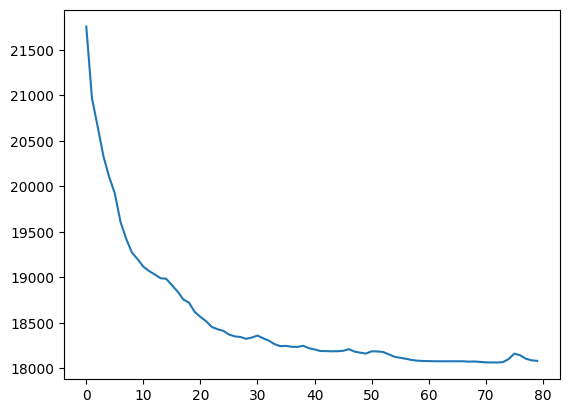

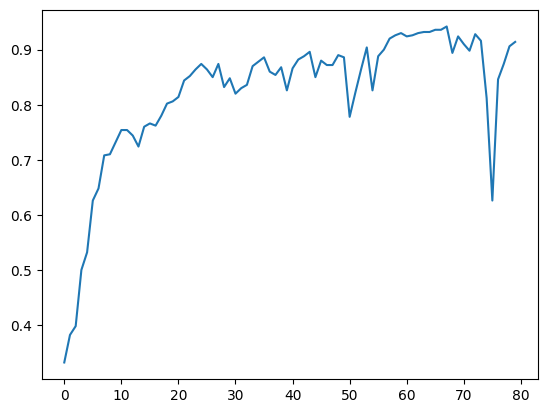

In [31]:
num_epochs = 80
splits = list(np.arange(0.1, 0.8, 0.1))
split_accs = []

for split in splits: 
    train_data, test_data = get_OF_splits(split, n_classes=100)
    loaders = get_loaders(train_data, test_data)
    cnn = get_resnet().to(device)
    losses, test_accs = train(num_epochs, cnn, loaders)
    best_acc = max(test_accs)
    print(f'best test accuracy after {num_epochs} epochs: {best_acc}')
    split_accs.append(best_acc)

# look at how the last model's training went:
plot_learning(losses, test_accs)

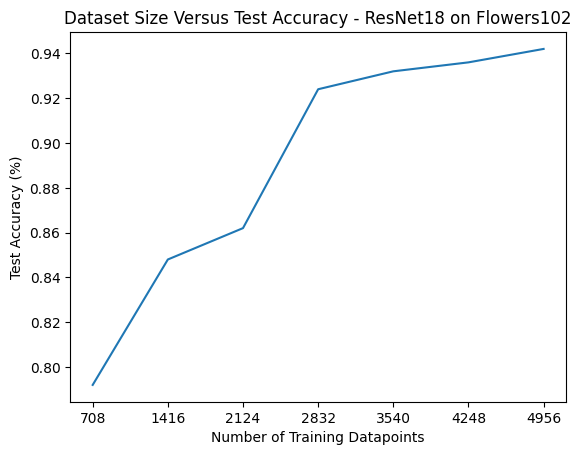

In [35]:
plt.figure()
plt.plot(split_accs)
plt.title('Dataset Size Versus Test Accuracy - ResNet18 on Flowers102')
data_sizes = list(range(1,len(split_accs)+1,1))
data_sizes = [x * 708 for x in data_sizes]
plt.xticks(range(0,len(split_accs),1), data_sizes)
plt.xlabel("Number of Training Datapoints")
plt.ylabel("Test Accuracy (%)")
plt.show()

#### ResNet18 on Flowers102. Increasing the number of classes (i.e. generating distributions / functions) decreases test accuracy:

number of train data points: 1020
number of test data points: 6149
number of train data points: 2833
number of test data points: 500
Epoch [1/60], Loss: 73.9469
Epoch [2/60], Loss: 68.2942
Epoch [3/60], Loss: 70.0492
Epoch [4/60], Loss: 69.3234
Epoch [5/60], Loss: 70.9019
Epoch [6/60], Loss: 71.8802
Epoch [7/60], Loss: 68.9431
Epoch [8/60], Loss: 67.8630
Epoch [9/60], Loss: 68.1899
Epoch [10/60], Loss: 69.6499
Epoch [11/60], Loss: 68.8906
Epoch [12/60], Loss: 67.0014
Epoch [13/60], Loss: 65.2134
Epoch [14/60], Loss: 69.3418
Epoch [15/60], Loss: 65.6448
Epoch [16/60], Loss: 65.9932
Epoch [17/60], Loss: 64.5104
Epoch [18/60], Loss: 69.5010
Epoch [19/60], Loss: 65.9037
Epoch [20/60], Loss: 61.9856
Epoch [21/60], Loss: 64.0074
Epoch [22/60], Loss: 66.9062
Epoch [23/60], Loss: 63.4300
Epoch [24/60], Loss: 63.1851
Epoch [25/60], Loss: 65.6230
Epoch [26/60], Loss: 65.1029
Epoch [27/60], Loss: 64.6418
Epoch [28/60], Loss: 62.9417
Epoch [29/60], Loss: 67.9980
Epoch [30/60], Loss: 62.1417
Epoch 

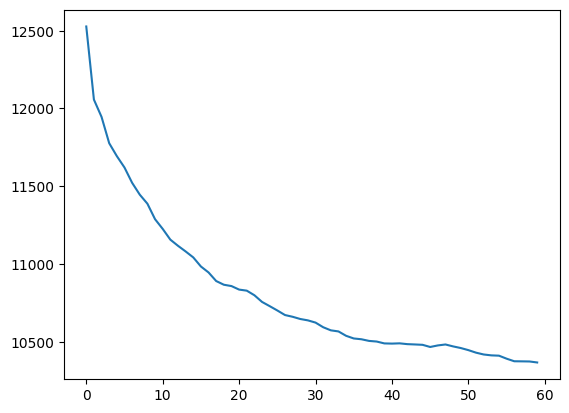

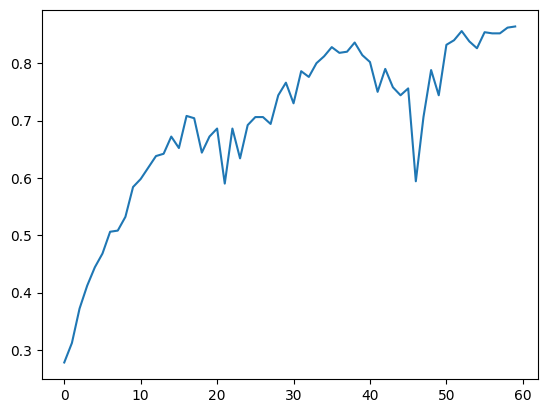

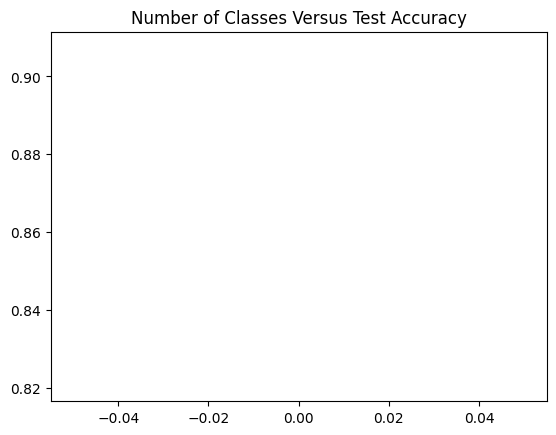

In [28]:
num_epochs = 60 # grows with number of classes!
n_classes = [100]#range(25, 101, 25)
n_class_accs = []

for n_class in n_classes: 
    train_data, test_data = get_OF_splits(0.4, n_classes=n_class)
    loaders = get_loaders(train_data, test_data)
    cnn = get_resnet().to(device)
    losses, test_accs = train(num_epochs, cnn, loaders)
    best_acc = max(test_accs)
    print(f'best test accuracy after {num_epochs} epochs: {best_acc}')
    n_class_accs.append(best_acc)

# look at how the last model's training went:
plot_learning(losses, test_accs)

plt.figure()
plt.plot(n_class_accs)
plt.title('Number of Classes Versus Test Accuracy')
plt.show()

#### Binary classifier with each class having many generating functions. 

We want to see what happens when multiple classes share the same label, and what happens when the number of shared classes with labels either 0 or 1 is increased. Interested to see how similar these results are to just increasing the number of classes normally (e.g. binary vs tertiary vs quarternary classifiers).